# Assessing the ICON-ModEx ML models

## How does the model score change with each ICON-ModEx iteration?
This notebook will harvest the data from the `dynamic-learning-rivers` repository to make a plot showing the evolution of the ML models as more traininig data is added.

## Important behind the scenes information
Here, I am assuming that this notebook is running in a Linux context (e.g. pull a [container that runs a local Jupyter server](https://hub.docker.com/r/jupyter/datascience-notebook) and open the notebook therein). This code will switch branches within a repository that it downloads from GitHub to load the data for side by side comparisions. It will then delete the source repository and retain only the harvested data used for plotting. The harvested data will be saved alongside this notebook here. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Clone source repository

In [2]:
org='parallelworks'
repo='dynamic-learning-rivers'
!git clone https://github.com/{org}/{repo}

Cloning into 'dynamic-learning-rivers'...
remote: Enumerating objects: 13675, done.
remote: Counting objects: 100% (1498/1498), done.
remote: Compressing objects: 100% (828/828), done.
remote: Total 13675 (delta 675), reused 1471 (delta 653), pack-reused 12177
Receiving objects: 100% (13675/13675), 2.95 GiB | 36.24 MiB/s, done.
Resolving deltas: 100% (6976/6976), done.
Updating files: 100% (166/166), done.


## Grab data and save to CSV
Here we want to track the model score over ModEx iterations.

In [3]:
# Start from fresh! Delete any .csv files that may already be here
!rm -f ICON-ModEx_automated_iterations.csv

# List the branches we want to work with
list_branches_scale = [
    'Jul-2022',
    'Aug-2022',
    'Sep-2022',
    'Oct-2022',
    'Nov-2022',
    'Dec-2022',
    'Jan-2023',
    'Feb-2023',
    'Mar-2023',
    'ICON-ModEx-v2.1-April-2023-replicate-01',
    'ICON-ModEx-v2.1-April-2023-replicate-02',
    'May-2023',
    'June-2023',
    'Jul-2023',
    'August-2023',
    'Sep-2023',
    'Oct-2023',
    'Nov-2023']

list_branches_log10 = [
    'Summer-2019-log10',
    'Jul-2022-log10',
    'Aug-2022-log10',
    'Sep-2022-log10',
    'Oct-2022-log10',
    'Nov-2022-log10',
    'Dec-2022-log10',
    'Jan-2023-log10',
    'Feb-2023-log10',
    'Mar-2023-log10',
    'Apr-2023-log10',
    'May-2023-log10',
    'June-2023-log10',
    'Jul-2023-log10',
    'August-2023-log10',
    'Sep-2023-log10',
    'Oct-2023-log10',
    'Nov-2023-log10']

# Initialize empty dataframes
icon_modex_log10 = pd.DataFrame(columns=['hold-out-avg','hold-out-std','ntrain'])
icon_modex_scale = pd.DataFrame(columns=['hold-out-avg','hold-out-std','ntrain'])

#=======================================
# Gather data over the standard branches
#=======================================
for bb,branch in enumerate(list_branches_scale):
    
    # Change to the requested branch
    !cd dynamic-learning-rivers; git checkout {branch}
    
    # We want to get the mean and std of the score and plot that vs the number of inputs to train.
    # Each dot will be an ICON-ModEx iteration.
    
    # This file summarizes the holdout score for all the
    # Superlearners for each ICON-ModEx iteration.
    holdout_score = pd.read_csv(
        repo+'/output_data/holdout_score.txt', 
        sep=':', 
        names=['Value','Number'], 
        index_col='Value' )
    #holdout_score = pd.read_csv(repo+'/output_data/holdout_score.txt', sep=':')
    
    # This file lists the total number of data available
    # (of which 25% is split to the testing set)
    input_data = pd.read_csv(repo+'/input_data/ICON-ModEx_Data.csv')
    
    icon_modex_scale.loc[len(icon_modex_scale.index)] = [
        holdout_score.loc['Avg',:].values[0],
        holdout_score.loc['Std',:].values[0],
        len(input_data.index)
    ]
    
    # We could also grab the histogram of CONUS predictions to check for an evolution of bias over time
    # Grab code from the Figure-2 harvestor notebook if needed.    

#=====================================
# Gather data over the -log10 branches
#=====================================
for bb,branch in enumerate(list_branches_log10):
    
    # Change to the requested branch
    !cd dynamic-learning-rivers; git checkout {branch}
    
    # We want to get the mean and std of the score and plot that vs the number of inputs to train.
    # Each dot will be an ICON-ModEx iteration.
    
    # This file summarizes the holdout score for all the
    # Superlearners for each ICON-ModEx iteration.
    holdout_score = pd.read_csv(
        repo+'/output_data/holdout_score.txt', 
        sep=':', 
        names=['Value','Number'], 
        index_col='Value' )
    #holdout_score = pd.read_csv(repo+'/output_data/holdout_score.txt', sep=':')
    
    # This file lists the total number of data available
    # (of which 25% is split to the testing set)
    input_data = pd.read_csv(repo+'/input_data/ICON-ModEx_Data.csv')
    
    icon_modex_log10.loc[len(icon_modex_log10.index)] = [
        holdout_score.loc['Avg',:].values[0],
        holdout_score.loc['Std',:].values[0],
        len(input_data.index)
    ]
    
    # We could also grab the histogram of CONUS predictions to check for an evolution of bias over time
    # Grab code from the Figure-2 harvestor notebook if needed.

# Save the intermediate results for reproducibility and
# offline plotting


Updating files: 100% (272/272), done.
branch 'Jul-2022' set up to track 'origin/Jul-2022'.
Switched to a new branch 'Jul-2022'
Updating files: 100% (185/185), done.
branch 'Aug-2022' set up to track 'origin/Aug-2022'.
Switched to a new branch 'Aug-2022'
Updating files: 100% (185/185), done.
branch 'Sep-2022' set up to track 'origin/Sep-2022'.
Switched to a new branch 'Sep-2022'
Updating files: 100% (185/185), done.
branch 'Oct-2022' set up to track 'origin/Oct-2022'.
Switched to a new branch 'Oct-2022'
Updating files: 100% (185/185), done.
branch 'Nov-2022' set up to track 'origin/Nov-2022'.
Switched to a new branch 'Nov-2022'
Updating files: 100% (185/185), done.
branch 'Dec-2022' set up to track 'origin/Dec-2022'.
Switched to a new branch 'Dec-2022'
Updating files: 100% (185/185), done.
branch 'Jan-2023' set up to track 'origin/Jan-2023'.
Switched to a new branch 'Jan-2023'
Updating files: 100% (185/185), done.
branch 'Feb-2023' set up to track 'origin/Feb-2023'.
Switched to a new br

# Load and plot data

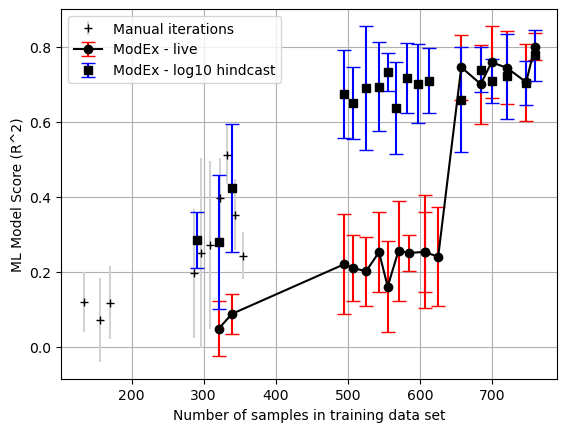

In [4]:
icon_modex_manual = pd.read_csv('ICON-ModEx_manual_iterations.csv')

# These iterations are the very first automated iterations
# presented at AGU2022. They were done in a "hindcast mode"
# to be able to compare to the manual iterations.
icon_modex_raw = pd.read_csv('ICON-ModEx_automated_iterations_raw.csv')

fig, ax = plt.subplots()
plt.errorbar(
    icon_modex_manual['ntrain'],
    icon_modex_manual[['hold-out','cv_avg']].max(axis=1),
    yerr=icon_modex_manual['cv_std'],
    fmt='k+',
    ecolor='lightgray',
    capsize=0)
#plt.errorbar(
#    icon_modex_raw['ntrain'],
#    icon_modex_raw['hold-out-avg'],
#    yerr=icon_modex_raw['hold-out-std'],
#    fmt='ko-',
#    ecolor='r',
#    capsize=5)
plt.errorbar(
    icon_modex_scale['ntrain'],
    icon_modex_scale['hold-out-avg'],
    icon_modex_scale['hold-out-std'],
    fmt='ko-',
    ecolor='r',
    capsize=5)
plt.errorbar(
    icon_modex_log10['ntrain'],
    icon_modex_log10['hold-out-avg'],
    icon_modex_log10['hold-out-std'],
    fmt='ks',
    ecolor='b',
    capsize=5)
ax.grid()
plt.ylabel('ML Model Score (R^2)')
plt.xlabel('Number of samples in training data set')
plt.legend(['Manual iterations','ModEx - live','ModEx - log10 hindcast'])
plt.savefig('ICON_ModEx_summary.pdf')

**Figure Caption:** Manual runs were done before AGU2022 as ICON-ModEx ramped up. The "live" iterations are the actual ICON-ModEx ML models that generated the results that were used for making decisions of which sites to sample. The hindcast iterations use a log10 filter because this reduces the bias of the ML models (see histogram analysis of Fig2). The big jump in the live iterations is due to the scaling of the respiration rate data with respect to the volume of the analysis container (need to double check this) (i.e. "Normalization") in June of 2023. The hindcast runs all take advantage of the scaling and the log10 transform to provide an apples-to-apples comparision of the progress of the ICON-ModEx iterations.